Autoencoder in PyTorch
===
Resource:
1. [What is representation learning?](https://www.quora.com/What-is-representation-learning-in-deep-learning)
2. [Representation learning overview](https://arxiv.org/pdf/1206.5538.pdf)
3. [Explain Auto Encoder](https://towardsdatascience.com/implementing-an-autoencoder-in-tensorflow-2-0-5e86126e9f7)
4. I take code from [here](https://github.com/udacity/deep-learning-v2-pytorch)
5. [AutoRec paper](https://users.cecs.anu.edu.au/~akmenon/papers/autorec/autorec-paper.pdf)

And please read more about 2 approaches of machine learning: **Generative** and **Discriminative** approach at:
1. Read introduction of [this lecture note ](http://cs229.stanford.edu/notes2020spring/cs229-notes2.pdf)
2. Read [here](https://en.wikipedia.org/wiki/Generative_model) to understand which models belong to which approach

Before diving into Variational Auto Encoder (VAE), we should know some terminologies:
1. What is representation learning?
2. What is Auto Encoder and its application?
3. What is latent vector and its application?

This notebook comprises of 3 parts:
1. Linear Auto Encoder
2. Convolution Auto Encoder
3. AutoRec: an application of Auto Encoder in Recommender System (not complete)

## Setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision

In [2]:
seed = 42
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

BATCH_SIZE = 512
EPOCHS = 20
LEARNING_RATE = 1e-3

## Dataset

We load our MNIST dataset using the `torchvision` package. 

In [3]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

train_dataset = torchvision.datasets.MNIST(
    root="../torch_datasets", train=True, transform=transform, download=True
)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True
)

test_dataset = torchvision.datasets.MNIST(
    root="../torch_datasets", train=False, transform=transform, download=True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=128, shuffle=False
)

Extracting ../torch_datasets\MNIST\raw\train-images-idx3-ubyte.gz to ../torch_datasets\MNIST\raw



Extracting ../torch_datasets\MNIST\raw\train-labels-idx1-ubyte.gz to ../torch_datasets\MNIST\raw


Extracting ../torch_datasets\MNIST\raw\t10k-images-idx3-ubyte.gz to ../torch_datasets\MNIST\raw


Extracting ../torch_datasets\MNIST\raw\t10k-labels-idx1-ubyte.gz to ../torch_datasets\MNIST\raw
Processing...
Done!


## Linear Autoencoder

An autoencoder is a type of neural network that finds the function mapping the features x to itself. This objective is known as reconstruction, and an autoencoder accomplishes this through the following process: (1) an encoder learns the data representation in lower-dimension space, i.e. extracting the most salient features of the data, and (2) a decoder learns to reconstruct the original data based on the learned representation by the encoder.

We define our autoencoder class with fully connected layers for both its encoder and decoder components.

In [4]:
class AutoEncoder(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        self.encoder_ = nn.Sequential(
            nn.Linear(kwargs['input_shape'], 512),
            nn.ReLU(),
            nn.Linear(512, 64),
            nn.ReLU(),
            nn.Linear(64, 16)
        )
        self.decoder_ = nn.Sequential(
            nn.Linear(16, 64),
            nn.ReLU(),
            nn.Linear(64, 512),
            nn.ReLU(),
            nn.Linear(512, kwargs['input_shape']),
            nn.Sigmoid()
        )

    def forward(self, features, get_latent=False):
        encode_vector = self.encoder_(features)

        if get_latent: return encode_vector

        reconstructed = self.decoder_(encode_vector)
        return reconstructed

Before using our defined autoencoder class, we have the following things to do:
    1. We configure which device we want to run on.
    2. We instantiate an `AE` object.
    3. We define our optimizer.
    4. We define our reconstruction loss.

In [5]:
#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
# create a model from `AE` autoencoder class
# load it to the specified device, either gpu or cpu
model = AutoEncoder(input_shape=784).to(device)

# create an optimizer object
# Adam optimizer with learning rate 1e-3
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# mean-squared error loss
criterion = nn.MSELoss()

cpu


We train our autoencoder for our specified number of epochs.

In [40]:
for epoch in range(EPOCHS):
    loss = 0
    for batch_features, _ in train_loader:
        # reshape mini-batch data to [N, 784] matrix
        # load it to the active device
        batch_features = batch_features.view(-1, 784).to(device)
        
        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
        optimizer.zero_grad()
        
        # compute reconstructions
        outputs = model(batch_features)
        
        # compute training reconstruction loss
        train_loss = criterion(outputs, batch_features)
        
        # compute accumulated gradients
        train_loss.backward()
        
        # perform parameter update based on current gradients
        optimizer.step()
        
        # add the mini-batch training loss to epoch loss
        loss += train_loss.item()
    
    # compute the epoch training loss
    loss = loss / len(train_loader)
    
    # display the epoch training loss
    print("epoch : {}/{}, recon loss = {:.8f}".format(epoch + 1, EPOCHS, loss))

epoch : 1/20, recon loss = 0.07798516
epoch : 2/20, recon loss = 0.04412724
epoch : 3/20, recon loss = 0.03043307
epoch : 4/20, recon loss = 0.02583960
epoch : 5/20, recon loss = 0.02329809
epoch : 6/20, recon loss = 0.02122296
epoch : 7/20, recon loss = 0.01969187
epoch : 8/20, recon loss = 0.01831237
epoch : 9/20, recon loss = 0.01715722
epoch : 10/20, recon loss = 0.01622817
epoch : 11/20, recon loss = 0.01555650
epoch : 12/20, recon loss = 0.01490889
epoch : 13/20, recon loss = 0.01432052
epoch : 14/20, recon loss = 0.01389181
epoch : 15/20, recon loss = 0.01342269
epoch : 16/20, recon loss = 0.01302924
epoch : 17/20, recon loss = 0.01267270
epoch : 18/20, recon loss = 0.01236889
epoch : 19/20, recon loss = 0.01210526
epoch : 20/20, recon loss = 0.01187596


In [6]:
# torch.save(model, 'linear_ae.pth')
model = torch.load('linear_ae.pth')

RuntimeError: version_ <= kMaxSupportedFileFormatVersion INTERNAL ASSERT FAILED at ..\caffe2\serialize\inline_container.cc:132, please report a bug to PyTorch. Attempted to read a PyTorch file with version 3, but the maximum supported version for reading is 2. Your PyTorch installation may be too old. (init at ..\caffe2\serialize\inline_container.cc:132)
(no backtrace available)

Let's extract some test examples to reconstruct using our trained autoencoder.

## Visualize Results

Let's try to reconstruct some test images using our trained autoencoder.

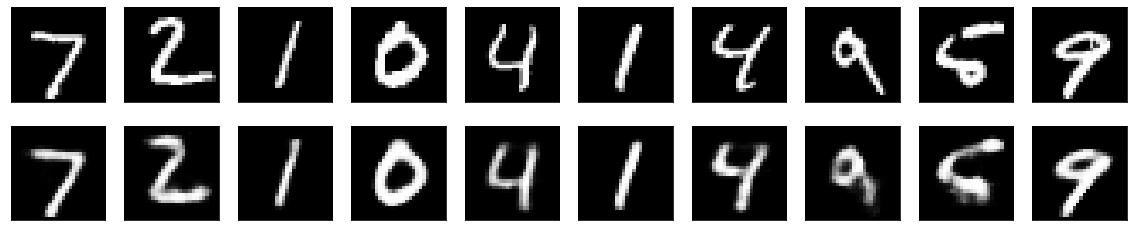

In [105]:
# Get some test examples
test_examples = None

with torch.no_grad():
    for batch_features, labels in test_loader:
        test_examples = batch_features.view(-1, 784)
        reconstruction = model(test_examples)
        latent_vector = model.forward(test_examples, get_latent=True)
        break

with torch.no_grad():
    number = 10
    plt.figure(figsize=(20, 4))
    for index in range(number):
        # display original
        ax = plt.subplot(2, number, index + 1)
        plt.imshow(test_examples[index].cpu().numpy().reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, number, index + 1 + number)
        plt.imshow(reconstruction[index].cpu().numpy().reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

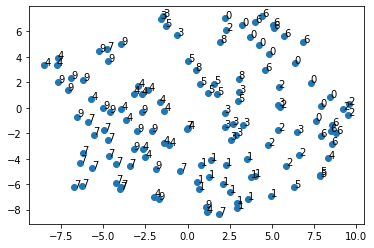

In [87]:
from sklearn.manifold import TSNE

# Embedding to 2D
tsne = TSNE(n_components=2, random_state=0)
z_embed = tsne.fit_transform(latent_vector)

# Plot
fig, ax = plt.subplots()
ax.scatter(z_embed[:,0], z_embed[:,1])

for i in range(len(z_embed)):
    ax.annotate(labels.numpy()[i], (z_embed[i,0], z_embed[i,1]))

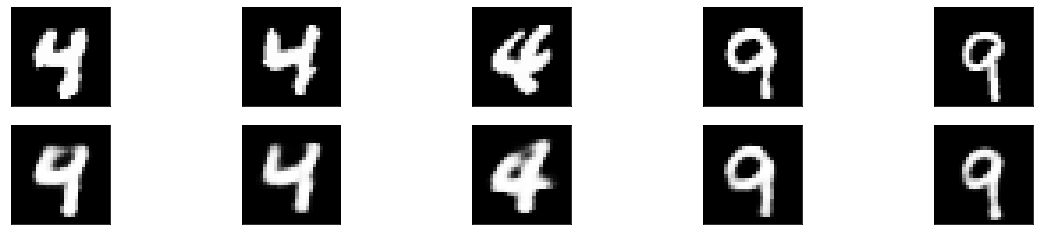

In [102]:
indices = np.where(z_embed[:,0] <= -7)[0]

with torch.no_grad():
    number = len(indices)
    plt.figure(figsize=(20, 4))
    for index, img in enumerate(indices):
        # print(img)
        # break
        # display original
        ax = plt.subplot(2, number, index + 1)
        plt.imshow(test_examples[img].cpu().numpy().reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, number, index + 1 + number)
        plt.imshow(reconstruction[img].cpu().numpy().reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

# CNN AutoEncoder

In [106]:
class CNNAutoencoder(nn.Module):
    def __init__(self):
        super(CNNAutoencoder, self).__init__()
        ## encoder layers ##
        # conv layer (depth from 1 --> 16), 3x3 kernels
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)  
        # conv layer (depth from 16 --> 4), 3x3 kernels
        self.conv2 = nn.Conv2d(16, 4, 3, padding=1)
        # pooling layer to reduce x-y dims by two; kernel and stride of 2
        self.pool = nn.MaxPool2d(2, 2)
        
        ## decoder layers ##
        ## a kernel of 2 and a stride of 2 will increase the spatial dims by 2
        self.t_conv1 = nn.ConvTranspose2d(4, 16, 2, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(16, 1, 2, stride=2)

    def forward(self, x):
        ## encode ##
        # add hidden layers with relu activation function
        # and maxpooling after
        x = torch.relu(self.conv1(x))
        x = self.pool(x)
        # add second hidden layer
        x = torch.relu(self.conv2(x))
        x = self.pool(x)  # compressed representation
        
        ## decode ##
        # add transpose conv layers, with relu activation function
        x = torch.relu(self.t_conv1(x))
        # output layer (with sigmoid for scaling from 0 to 1)
        x = torch.sigmoid(self.t_conv2(x))
                
        return x

# initialize the NN
model = CNNAutoencoder()
print(model)

CNNAutoencoder(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): ConvTranspose2d(4, 16, kernel_size=(2, 2), stride=(2, 2))
  (t_conv2): ConvTranspose2d(16, 1, kernel_size=(2, 2), stride=(2, 2))
)


In [107]:
# specify loss function
criterion = nn.MSELoss()

# specify loss function
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [108]:
for epoch in range(1, EPOCHS+1):
    # monitor training loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for data in train_loader:
        # _ stands in for labels, here
        # no need to flatten images
        images, _ = data
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        outputs = model(images)
        # calculate the loss
        loss = criterion(outputs, images)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*images.size(0)
            
    # print avg training statistics 
    train_loss = train_loss/len(train_loader)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch, 
        train_loss
        ))

Epoch: 1 	Training Loss: 92.743593
Epoch: 2 	Training Loss: 32.376792
Epoch: 3 	Training Loss: 18.891696
Epoch: 4 	Training Loss: 12.507388
Epoch: 5 	Training Loss: 11.012061
Epoch: 6 	Training Loss: 10.283516
Epoch: 7 	Training Loss: 9.891018
Epoch: 8 	Training Loss: 9.630630
Epoch: 9 	Training Loss: 9.420842
Epoch: 10 	Training Loss: 9.238320
Epoch: 11 	Training Loss: 9.069900
Epoch: 12 	Training Loss: 8.904318
Epoch: 13 	Training Loss: 8.737961
Epoch: 14 	Training Loss: 8.564659
Epoch: 15 	Training Loss: 8.390342
Epoch: 16 	Training Loss: 8.226818
Epoch: 17 	Training Loss: 8.083514
Epoch: 18 	Training Loss: 7.959562
Epoch: 19 	Training Loss: 7.851233
Epoch: 20 	Training Loss: 7.760151


In [110]:
torch.save(model, 'cnn_ae.pth')

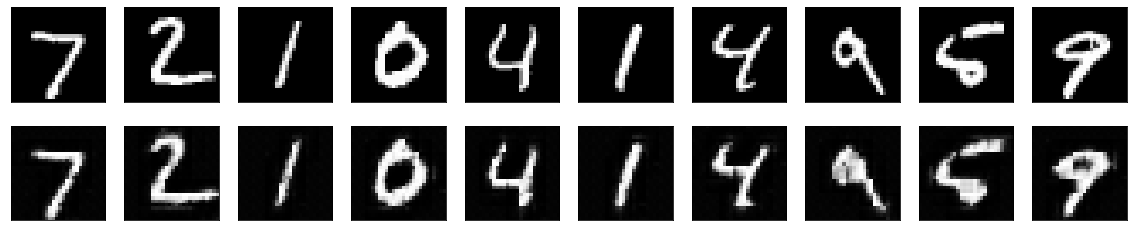

In [ ]:
test_examples = None

with torch.no_grad():
    for batch_features in test_loader:
        test_examples = batch_features[0]
        reconstruction = model(test_examples)
        break

with torch.no_grad():
    number = 10
    plt.figure(figsize=(20, 4))
    for index in range(number):
        # display original
        ax = plt.subplot(2, number, index + 1)
        plt.imshow(test_examples[index].numpy().reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, number, index + 1 + number)
        plt.imshow(reconstruction[index].numpy().reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()